In [1]:
# add path (for local)
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2

from rdkit import RDLogger
from utils import generator_from_conf, conf_from_yaml
RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        conf = conf_from_yaml(yaml_path, repo_root)
        generator = generator_from_conf(conf, repo_root)
        generate_and_analyze(generator, conf)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/home/fujii/anaconda3/envs/v3-forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting generation...


order: 360, time: 438.37, reward: 0.3130, node: [C][C][/C][=C][\C][/C][=C][\C][/C][=C][\C][=C][\C][=C][\C@@H1][Branch1][C][O][C][C][C][C][=Branch1][C][=O][O-1]
order: 361, time: 438.37, reward: 0.2813, node: [C][C][/C][=C][\C][/C][=C][\C][=C][\C][=Branch1][C][=O][C][/C][=C][\C][C][C][C][=Branch1][C][=O][O-1]
order: 362, time: 439.45, reward: 0.5936, node: [C][C][O][C][=Branch1][C][=O][/C][=C][\C][/C][=C][\C][=C][\C][C][/C][=C][\C][=C][\C][C][C][C][=C][C][=C][Branch1][C][C][C][=C][Ring1][#Branch1]
order: 363, time: 439.45, reward: 0.6748, node: [C][C][/C][=C][\C][/C][=C][\C][/C][=C][\C][=C][\C][Branch1][=N][C][C][C][=C][C][=C][Branch1][C][C][C][=C][Ring1][#Branch1][O][C][=Branch1][C][=O][C][C][C][=C][C][=C][Branch1][C][C][C][=C][Ring1][#Branch1]
order: 364, time: 441.09, reward: 0.6983, node: [C][C][O][C][=Branch1][C][=O][C][C][C][/C][=C][\C][/C][=C][\C][/C][=C][\C][=C][\C][Branch1][C][C][=C][\C][=C][\C][=C][Branch1][C][C][C][=C][C][=C][Branch1][C][C][C][=C][Ring1][#Branch1]
order: 365,

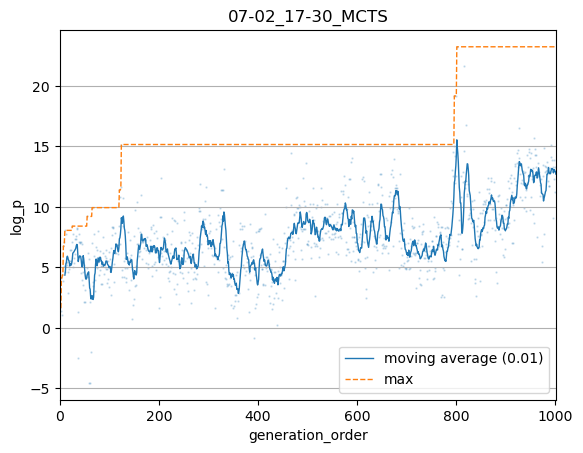

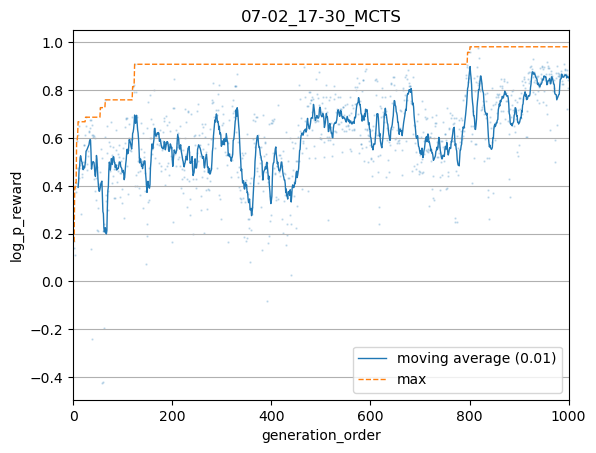

number of generated nodes: 1001
valid rate: 1.0
unique rate: 1.0
node_per_sec: 0.7618432396370881
best_reward: 0.9809597204113281
average_reward: 0.6040331546869216


In [7]:
# start / continue generation

yaml_path = "config/mcts_helm.yaml"
yaml_path = "config/mcts_smiles.yaml"
yaml_path = "config/model_test.yaml"
yaml_path = "config/mcts_d_score.yaml"
yaml_path = "config/mcts_biot5.yaml"

if "generator" in locals():
    generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()
else:
    conf = conf_from_yaml(yaml_path, repo_root)
    generator = generator_from_conf(conf, repo_root)
    generate_and_analyze(generator, conf)
    
# queue_generations(c1, c2)

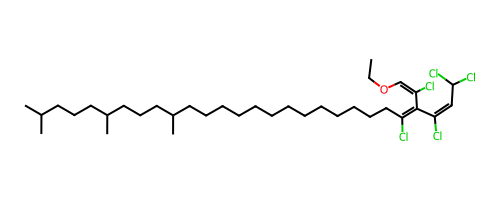

In [14]:
from node import MolStringNode
from language import SELFIES
from utils import draw_mol
x = MolStringNode.node_from_key("[C][C][O][C][=C][Branch1][C][Cl][C][=C][Branch1][C][Cl][C][Branch2][Ring2][=Branch2][C][C][C][C][C][C][C][C][C][C][C][C][C][Branch1][C][C][C][C][C][C][Branch1][C][C][C][C][C][C][Branch1][C][C][C].[Cl][=C][Branch1][C][Cl][C][=C][Ring2][Ring2][C][Cl]", lang=SELFIES())
mol = x.mol()
draw_mol(mol, 500, 200)

In [8]:
generator.reward.objective_values_and_reward(generator.root)

([1.6866], np.float64(0.16707874472795056))

In [16]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load generator and yaml
load_dir = "generation_result/06-26_08-51/"
generator, conf = read_yaml("sandbox/" + load_dir + "setting.yaml")
generator = Generator.load(load_dir + "save.mcts", generator.transition)

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)